# 003 - Feature Engineering, Tuning & XGBoost

## Objectifs
1. **Feature Engineering** : Créer des variables synthétiques pertinentes (Surface totale, Âge, etc.) pour aider le modèle.
2. **Tuning** : Optimiser les hyperparamètres de XGBoost via `RandomizedSearchCV`.
3. **Pipeline** : Intégrer le tout proprement pour éviter le data leakage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Ajout du dossier src au path pour importer features.py
sys.path.append("../src")
from features import add_features

from sklearn.model_selection import KFold, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from xgboost import XGBRegressor

sns.set_style("whitegrid")
%matplotlib inline

## 1. Chargement et Feature Engineering

In [2]:
TRAIN_PATH = "../Data/train.csv"
TEST_PATH = "../Data/test.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

X = train_df.drop(columns=["SalePrice"])
y = train_df["SalePrice"]

# Aperçu des nouvelles features
X_fe = add_features(X)
new_cols = ["TotalSF", "TotalBath", "Age", "RemodAge", "TotalPorchSF", "HasPool", "HasGarage", "HasBasement", "HasFireplace"]
X_fe[new_cols].head()

,TotalSF,TotalBath,Age,RemodAge,TotalPorchSF,HasPool,HasGarage,HasBasement,HasFireplace
0,2566,3.5,5,5,61,0,1,1,0
1,2524,2.5,31,31,0,0,1,1,1
2,2706,3.5,7,6,42,0,1,1,1
3,2473,2.0,91,36,307,0,1,1,1
4,3343,3.5,8,8,84,0,1,1,1


### Corrélation avec la cible
Regardons si `TotalSF` est bien corrélé au prix (sur le train set).

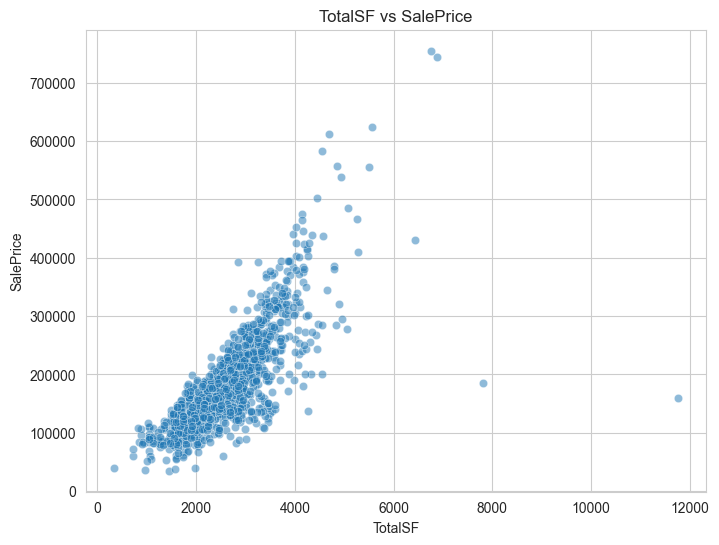

In [3]:
train_fe = add_features(train_df)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_fe, x="TotalSF", y="SalePrice", alpha=0.5)
plt.title("TotalSF vs SalePrice")
plt.show()

## 2. Construction de la Pipeline Complète

Il est crucial de définir quelles colonnes sont numériques et lesquelles sont catégorielles **après** le Feature Engineering.
Comme `ColumnTransformer` s'applique après `add_features`, nous devons être astucieux.

**Stratégie** : 
1. `FunctionTransformer` applique `add_features`.
2. `ColumnTransformer` sélectionne les colonnes par type (automatique si on lui passe le dataframe complet) OU on définit les noms de colonnes explicitement.

Pour simplifier dans `scikit-learn`, on peut utiliser `make_column_selector` si on a une version récente, ou lister manuellement. Ici, nous allons lister les colonnes initiales ET ajouter les nouvelles.

In [4]:
# Colonnes initiales (hors SalePrice)
numeric_features = list(X.select_dtypes(include=["int64", "float64"]).columns)
categorical_features = list(X.select_dtypes(include=["object"]).columns)

# Ajout des nouvelles features numériques
numeric_features.extend(new_cols)

# Preprocessing
numeric_transformer = SimpleImputer(strategy="median")

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Modèle XGBoost
xgb = XGBRegressor(random_state=42, n_jobs=-1)

# Pipeline interne (sans la target transform pour le grid search, ou avec ?)
# Si on veut tuner AVEC la transformation de cible, il faut que TransformedTargetRegressor soit le dernier étape.
# MAIS TransformedTargetRegressor cache les paramètres du régresseur interne avec le préfixe 'regressor__'.

pipeline = Pipeline(steps=[
    ("feature_engineering", FunctionTransformer(add_features, validate=False)),
    ("preprocessor", preprocessor),
    ("model", xgb)
])

# Pipeline finale avec Log Target
final_model = TransformedTargetRegressor(
    regressor=pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

## 3. Tuning Hyperparamètres (RandomizedSearchCV)

In [5]:
# Espace de recherche
# Attention : le param 'model' est dans 'regressor' de TransformedTargetRegressor, 
# et 'model' est le nom de l'étape XGB dans la pipeline.
# Donc : regressor__model__param

param_dist = {
    "regressor__model__n_estimators": [1500, 2500, 4000, 6000],
    "regressor__model__learning_rate": [0.01, 0.02, 0.03, 0.05],
    "regressor__model__max_depth": [3, 4, 5],
    "regressor__model__min_child_weight": [1, 3, 5],
    "regressor__model__subsample": [0.6, 0.75, 0.85, 1.0],
    "regressor__model__colsample_bytree": [0.6, 0.75, 0.85, 1.0],
    "regressor__model__reg_alpha": [0.0, 0.1, 0.5],
    "regressor__model__reg_lambda": [0.5, 1.0, 2.0]
}

search = RandomizedSearchCV(
    estimator=final_model,
    param_distributions=param_dist,
    n_iter=20, # Limité pour la rapidité
    scoring="neg_mean_absolute_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Début du tuning...")
search.fit(X, y)
print(f"Meilleurs paramètres : {search.best_params_}")
print(f"Meilleur score CV (MAE) : {-search.best_score_:.4f}")

Début du tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres : {'regressor__model__subsample': 0.75, 'regressor__model__reg_lambda': 0.5, 'regressor__model__reg_alpha': 0.0, 'regressor__model__n_estimators': 4000, 'regressor__model__min_child_weight': 3, 'regressor__model__max_depth': 5, 'regressor__model__learning_rate': 0.01, 'regressor__model__colsample_bytree': 0.75}
Meilleur score CV (MAE) : 14781.9143


## 4. Évaluation Complète (MAE + MAPE)

In [6]:
best_model = search.best_estimator_

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']

scores = cross_validate(best_model, X, y, cv=cv, scoring=scoring, n_jobs=-1)

mae = -scores['test_neg_mean_absolute_error']
mape = -scores['test_neg_mean_absolute_percentage_error']

print(f"MAE: {mae.mean():.2f} +/- {mae.std():.2f}")
print(f"MAPE: {mape.mean()*100:.2f}% +/- {mape.std()*100:.2f}%")

MAE: 14806.84 +/- 1540.52
MAPE: 8.53% +/- 1.01%


## 5. Soumission

In [7]:
best_model.fit(X, y)
predictions = best_model.predict(test_df)

submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": predictions
})

submission.head()

,Id,SalePrice
0,1461,127043.250000
1,1462,162525.015625
2,1463,187872.859375
3,1464,193507.109375
4,1465,183129.671875
